In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os, json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

%matplotlib inline

### Image resolution
- Maximum 500
- Minimum 128
- Only approximately 120 images from 8000 in total that have resolution less than 256
- ***Setting resolution to 256x256 maybe a good choice.***

<br />

### Transfer learning choices
EfficientNet becoming the best choice because they have high accuracy with fewer parameters
- EfficientNetB0 (224, 224, 3) *** --> We will use this one.
- EfficientNetB1 (240, 240, 3)
- EfficientNetB2 (260, 260, 3)
- EfficientNetB3 (300, 300, 3)
- EfficientNetB4 (380, 380, 3)

In [2]:
# img_path = path to folder of image
# json_path = path to karpathy's json file ## dataset choices

img_path = 'dataset/Flicker8k_Dataset/'
json_path = 'caption_datasets/dataset_flickr8k.json'

In [3]:
from source.utils import prepare_data, Create_image_caption_pair
from source.Dataset import ImgCaption_Dataset

In [4]:
# Split dataset
train_img, train_cap, val_img, val_cap, test_img, test_cap, vocab_dict = prepare_data(img_path, json_path, 5)

In [5]:
# This function Create image_path and caption Encoding pair for any split
# Note that this function map caption word to token ("a dog is playing" --> [1, 4, 5, 8, 132, 2])
train_X, train_Y, train_caplen = Create_image_caption_pair(train_img, train_cap, vocab_dict, 25)
val_X, val_Y, val_caplen = Create_image_caption_pair(val_img, val_cap, vocab_dict, 25)
test_X, test_Y, test_caplen = Create_image_caption_pair(test_img, test_cap, vocab_dict, 25)

In [6]:
# Define Image transformation
# Since we using pretrained from ImageNet, Normalization mean and std are also from ImageNet.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

# Get pair from Custom Datset
train_data = ImgCaption_Dataset(train_X, train_Y, train_caplen, transform)
valid_data = ImgCaption_Dataset(val_X, val_Y, val_caplen, transform)
test_data = ImgCaption_Dataset(test_X, test_Y, test_caplen, transform)

# pytorch Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, pin_memory=True)

In [7]:
# Just Testing function
data = next(iter(train_loader))  

In [8]:
def denormalize(img ,mean, std):
    img[0, :, :] = (img[0, :, :] * std[0]) + mean[0]
    img[1, :, :] = (img[1, :, :] * std[1]) + mean[1]
    img[2, :, :] = (img[2, :, :] * std[2]) + mean[2]
    return img

def get_caption_back(token, vocab):
    caption = ""
    for tok in token:
        if tok == 0:
            break
        word = list(vocab_dict.keys())[list(vocab_dict.values()).index(tok)]
        caption += str(word) + " "
    return caption

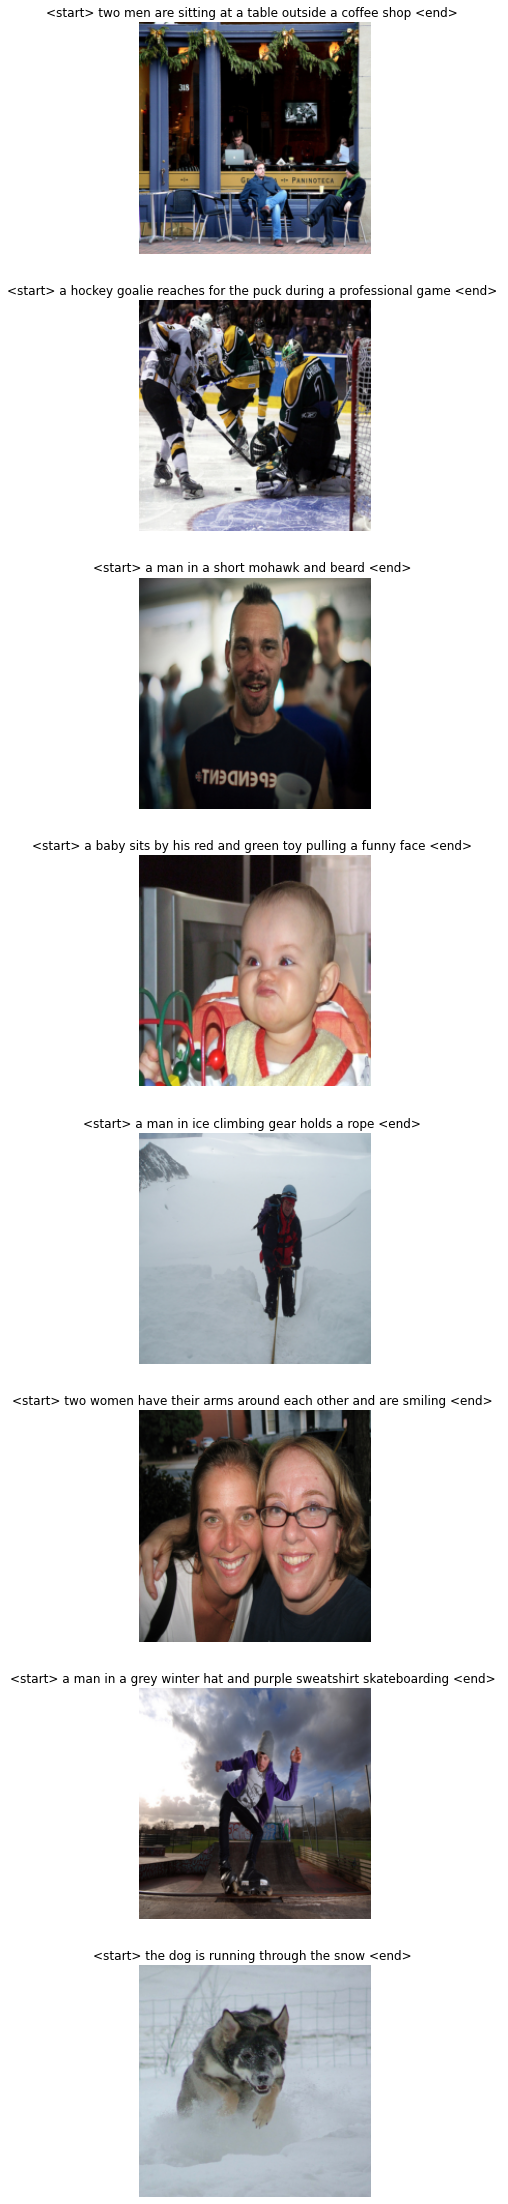

In [9]:
fig, ax = plt.subplots(8, 1, figsize=(40,40))
for i in range(8):
    img = denormalize(np.array(data[0][i]), mean, std)
    ax[i].set_title(get_caption_back(data[1][i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()

# Models exploration
<br>

#### BASELINE:
- Very simple Encoder-Decoder
- Encoder --> CNN (Pretrained backbone)
- Decoder --> RNN, GRU, LSTM (choices)


In [10]:
import torchvision.models as models
from torch import nn
from tqdm import tqdm

from source.model import Encoder, Decoder # import model
from source.helper import train, evaluate # import helper function

In [11]:
# initialize parameters 
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 1 # this is a limitation for inference time
EPOCH = 5

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    "latent_size": 256,
    "hidden_layer": 512,
    "vocab_size": len(vocab_dict),
    "lr": 0.01
}

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=valid_data, batch_size=TEST_BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, pin_memory=True)

In [13]:
# Backbone
# Pretrained model is our choices.
effnet = models.efficientnet_b0(pretrained=True)

In [14]:
# Define model
encoder = Encoder(effnet, effnet.classifier[1].in_features, config["latent_size"]).to(device)
decoder = Decoder(config["latent_size"], config["hidden_layer"], 2, config["vocab_size"]).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + \
        list(encoder.latent1.parameters()) + \
        list(encoder.latent2.parameters()) + \
        list(encoder.batchnorm1.parameters()) + \
        list(encoder.batchnorm2.parameters())

optimizer = torch.optim.AdamW(params, lr=0.001)

In [16]:
for epoch in range(EPOCH):
    print("On Epoch: ", epoch, " . . .")
    loss = train(encoder, decoder, device, train_loader, optimizer, criterion)
    #val_loss, preds, labels = evaluate(encoder, decoder, device, val_loader, criterion)
    #print("Validation loss : ", val_loss, "\n")

On Epoch:  0  . . .
Train step [0 / 117], loss :  7.883331298828125
Train step [10 / 117], loss :  5.346703052520752
Train step [20 / 117], loss :  4.9732561111450195
Train step [30 / 117], loss :  4.519684314727783
Train step [40 / 117], loss :  4.32313346862793
Train step [50 / 117], loss :  4.092098712921143
Train step [60 / 117], loss :  3.963688373565674
Train step [70 / 117], loss :  3.883833646774292
Train step [80 / 117], loss :  3.7205276489257812
Train step [90 / 117], loss :  3.6106786727905273
Train step [100 / 117], loss :  3.5474512577056885
Train step [110 / 117], loss :  3.5991976261138916
On Epoch:  1  . . .
Train step [0 / 117], loss :  3.4302871227264404
Train step [10 / 117], loss :  3.424851655960083
Train step [20 / 117], loss :  3.4733033180236816
Train step [30 / 117], loss :  3.2286124229431152
Train step [40 / 117], loss :  3.3018476963043213
Train step [50 / 117], loss :  3.232182741165161
Train step [60 / 117], loss :  3.1512832641601562
Train step [70 / 117

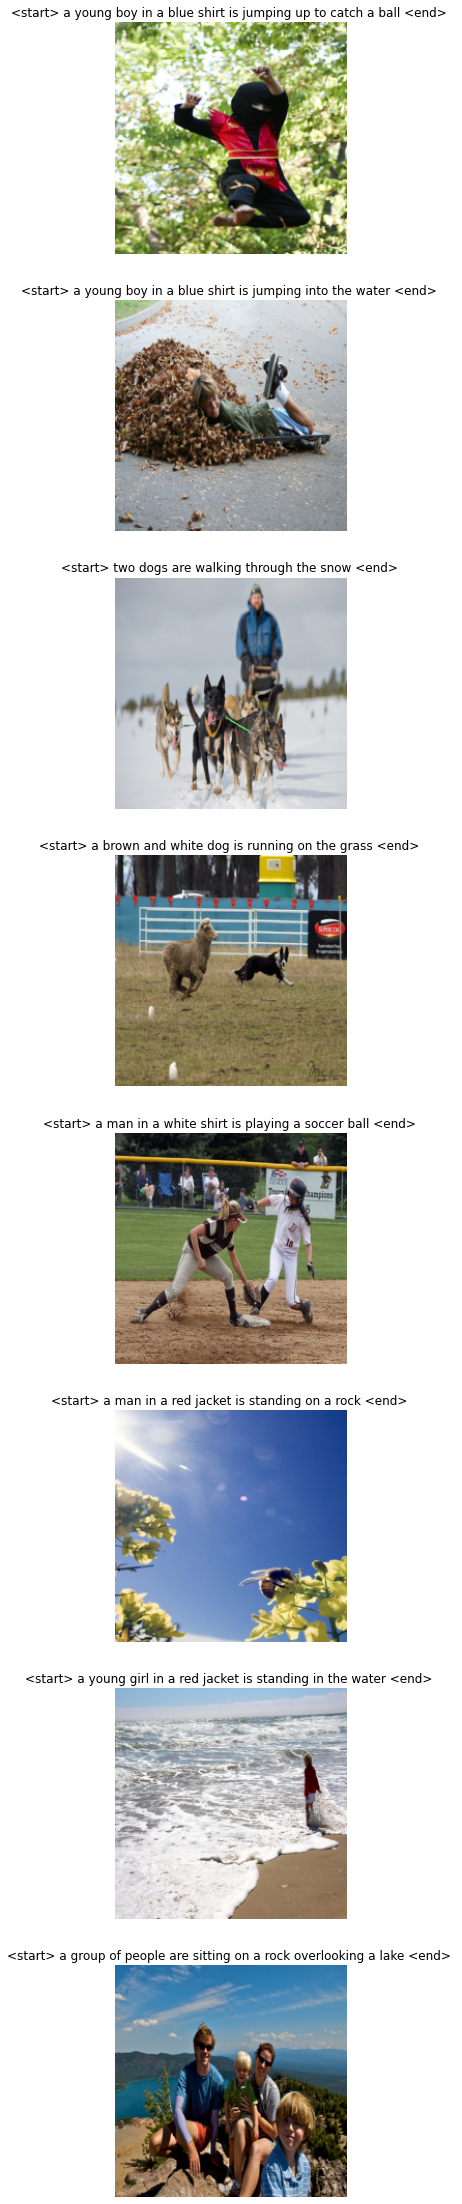

In [22]:
# Get Prediction from validation set
fig, ax = plt.subplots(8, 1, figsize=(40,40))
for i in range(8):
    val_data = next(iter(val_loader))
    encoder.eval()
    decoder.eval()
    x = encoder(val_data[0].cuda())
    # At inference time, input should be only img latent.
    out = decoder.inference(x)
    
    img = denormalize(np.array(val_data[0].squeeze()), mean, std)
    ax[i].set_title(get_caption_back(out, vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()